<a href="https://colab.research.google.com/github/rshibaki/github_practice/blob/main/Furuta_dicision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Google driveにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn import tree      # for decision trees
from sklearn import ensemble  # for random forests
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
xlsx_input = input("入力データが保管してあるドライブの絶対パス: ") or "/content/drive/MyDrive/Furuta/AE-FILD_BAL_patient_data.xlsx"
!cp {xlsx_input} patient_data.xlsx

入力データが保管してあるドライブの絶対パス: 


In [4]:
# openpyxlというエンジンを使用して、ExcelファイルをPandasのデータフレームとして読みこむ
#!pip install openpyxl
import pandas as pd
AE_FILD_df = pd.read_excel('patient_data.xlsx', engine='openpyxl')

In [5]:
# ヘルパーファンクションでテキスト内の"\n"をスペースに変換する
def clean_header(text):
  text_n_newline = text.replace("\n", " ")
  return text_n_newline

In [6]:
# ヘッダーコラムのテキストをリストとして変換する
AE_FILD_header_list = AE_FILD_df.columns.values.tolist()
AE_FILD_header_list

#　上記のヘッダーリストにclean_header()を応用する
AE_FILD_header_list_cleaned = [clean_header(x) for x in AE_FILD_header_list]
print(AE_FILD_header_list_cleaned)

AE_FILD_df.columns = AE_FILD_header_list_cleaned
AE_FILD_df.head()

['No', 'ID', '90day mortality survival:0 death:1', 'sex male:0 female:1', 'age ', 'smoking status Never:0 Ex(quit smoking over a year ago):1 Current:2', 'Brinkman Index', 'emphysema (-):0 (+):1', 'Baseline ILD UIP:0 probable UIP:1 Indeterminate for UIP:2 Alternative diagnosis:3', 'Collagen disease (-):0 (+):1', 'IPAF (-):0 (+):1', 'P/F ratio', 'LDH', 'CRP', 'KL-6', ' BAL(neutro %)', ' BAL(Lymph %)', ' BAL(Eos %)', ' BAL(M %)', ' BAL(CD4/8)', 'MMP-1', 'MMP-7', 'TGFB1', 'TGFB2', 'TGFB3', 'EGF', 'FGF-2', 'EOTAXIN', 'TGF-a', 'G-CSF', 'Flt-3L', 'GM-CSF', 'FRACTALKINE', 'IFN-a2', 'IFN-g', 'GRO', 'IL-10', 'MCP-3', 'IL-12P40', 'MDC', 'IL-12P70', 'IL-13', 'IL-15', 'sCD40L', 'IL-17', 'IL-1RA', 'IL-1a', 'IL-9', 'IL-1b', 'IL-2', 'IL-3', 'IL-4', 'IL-5', 'IL-6', 'IL-7', 'IL-8', 'IP-10', 'MCP-1', 'MIP-1a', 'MIP-1b', 'TNFa', 'TNFb', 'VEGF', 'IL-36β']


,No,ID,90day mortality survival:0 death:1,sex male:0 female:1,age,smoking status Never:0 Ex(quit smoking over a year ago):1 Current:2,Brinkman Index,emphysema (-):0 (+):1,Baseline ILD UIP:0 probable UIP:1 Indeterminate for UIP:2 Alternative diagnosis:3,Collagen disease (-):0 (+):1,...,IL-7,IL-8,IP-10,MCP-1,MIP-1a,MIP-1b,TNFa,TNFb,VEGF,IL-36β
0,K003,558277,0,0,78,1,1600,0,1,0,...,3.2,313.439925,2160.940947,1009.878650,28.906316,30.940577,4.483265,3.2,3.2,4.221958
1,K022,1848827,0,1,72,0,0,0,2,0,...,3.2,325.398968,15647.940247,1943.663852,25.105166,25.342591,24.074274,3.2,3.2,2.000000
2,K024,1902349,0,0,86,0,0,0,2,0,...,3.2,35.723941,2807.826476,243.983235,5.912140,23.698467,8.748703,3.2,3.2,2.000000
3,K043,3165531,0,0,58,1,500,0,2,0,...,3.2,87.506323,3908.900383,637.958551,3.518690,14.870714,NaN,3.2,3.2,2.000000
4,K045,3253683,0,0,76,1,800,0,3,0,...,3.2,179.661551,2575.467315,3495.474916,31.821785,100.036875,21.233261,3.2,3.2,2.000000


In [7]:
selected_col_names=[
    'MMP-1', 
    'GM-CSF', 
    'IL-6',
    'IL-8',
    'MCP-1',
    'EOTAXIN',
    '90day mortality survival:0 death:1'
    ]

In [8]:
X = AE_FILD_df[selected_col_names]
X = X.drop(labels=['90day mortality survival:0 death:1'], axis=1)
Y = AE_FILD_df[['90day mortality survival:0 death:1']]

display(X.head())
display(Y.head())

,MMP-1,GM-CSF,IL-6,IL-8,MCP-1,EOTAXIN
0,664.773204,3.200000,23.016166,313.439925,1009.878650,10.963133
1,561.092206,4.635806,60.512609,325.398968,1943.663852,15.963448
2,57.921345,3.200000,3.200000,35.723941,243.983235,5.767947
3,292.713992,3.200000,24.517336,87.506323,637.958551,9.398526
4,645.580358,3.200000,240.737287,179.661551,3495.474916,36.132460


,90day mortality survival:0 death:1
0,0
1,0
2,0
3,0
4,0


In [10]:
X_df_null_val = list(X.isna().sum()) #　データセット内にNaN値が無いかの確認
print(f"X_idfデータフレーム内のNaN数：{X_df_null_val}")
Y_df_null_val = list(Y.isna().sum()) #　データセット内にNaN値が無いかの確認
print(f"Y_idfデータフレーム内のNaN数：{Y_df_null_val}")

X_idfデータフレーム内のNaN数：[0, 1, 4, 0, 0, 5]
Y_idfデータフレーム内のNaN数：[0]


In [11]:
# データセット内のNaN値をどうするか (まずはinputer transformで試してみる)
from sklearn.impute import SimpleImputer
X.replace('NaN', np.NaN, inplace=True) # データフレーム内の"NaN"をnumpyのNaNと置き換える
imp = SimpleImputer(missing_values=np.NaN, strategy="median") # sklearnのSimpleImputerを使い、np.NaNをnull値として認識させる。加、strategy="median"はnp.NaNをその行のNaNを中央値と置き換えるための指定
X_idf = pd.DataFrame(imp.fit_transform(X))
X_idf.columns = X.columns # SimpleImputerは数値しか作成できない為、元のデータセットの行名を新しいデータセットに加るコード
df_null_val = list(X_idf.isna().sum()) #　データセット内にNaN値が無いかの確認
print(f"X_idfデータフレーム内のNaN数：{df_null_val}")
X_idf.head()

X_idfデータフレーム内のNaN数：[0, 0, 0, 0, 0, 0]


,MMP-1,GM-CSF,IL-6,IL-8,MCP-1,EOTAXIN
0,664.773204,3.200000,23.016166,313.439925,1009.878650,10.963133
1,561.092206,4.635806,60.512609,325.398968,1943.663852,15.963448
2,57.921345,3.200000,3.200000,35.723941,243.983235,5.767947
3,292.713992,3.200000,24.517336,87.506323,637.958551,9.398526
4,645.580358,3.200000,240.737287,179.661551,3495.474916,36.132460


In [18]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_idf, Y)

Score Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.90      0.95        10

    accuracy                           0.98        60
   macro avg       0.99      0.95      0.97        60
weighted avg       0.98      0.98      0.98        60



Text(83.40000000000006, 0.5, 'Pred Labe')

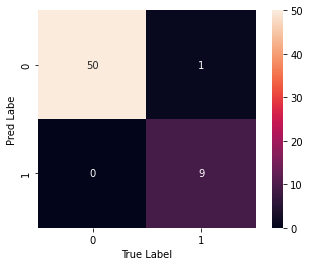

In [19]:
Y_pred = tree_clf.predict(X_idf)

#精度評価
from sklearn.metrics import classification_report

print('Score Report')
print(classification_report(Y, Y_pred))

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

matrix = confusion_matrix(Y, Y_pred)

sns.heatmap(matrix.T, square=True, annot=True)
plt.xlabel('True Label')
plt.ylabel('Pred Labe')

<function matplotlib.pyplot.show(*args, **kw)>

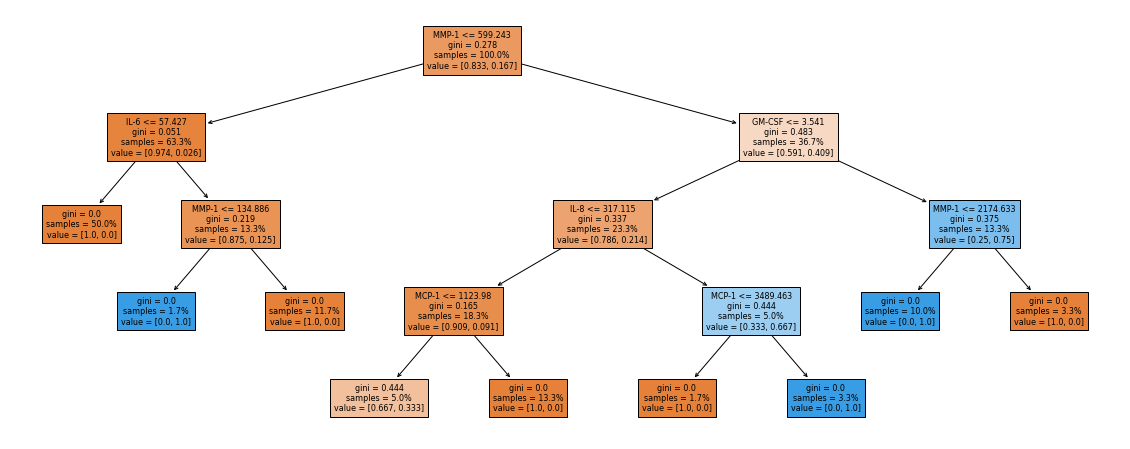

In [22]:
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 8))
tree.plot_tree(tree_clf, feature_names=X_idf.columns, filled=True, proportion=True, fontsize=8)
plt.show

In [ ]:
# 今回の機械学習に使うライブラリーはsklearnのRF解析
#　sklearnが機械学習モデルを適応できるようにデータをnumpyのarrayに変換する
X = X_idf.values #.valuesはnumpy arrayを出力する　
Y = Y.values

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold



# cross validationを使い、階層や決定木の数をチューニングしてみる（ハイパーパラメーター）
# 注：過適合/過剰適合のバランスを見極めながらハイパーパラメーターチューニングを行う
best_accuracy = 0
best_depth = 1
best_num_trees = 42

for ntrees in range(50,450,100):  # 決定木50から350の間（ステップ数：100)
    for d in range(1,20): # 階層1から20の間
        rforest_model = ensemble.RandomForestClassifier(
            n_estimators= ntrees,
            criterion='entropy',
            max_depth=d,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=0,
            verbose=0,
            warm_start=False,
            class_weight='balanced'
        )
        k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # 5-fold, StratifiedKFoldはインバランスデータで偏りなく分割できるKfold
        cv_scores = cross_val_score(estimator=rforest_model, X=X, y=Y, cv=k_fold )
        average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る
        if average_cv_accuracy >= best_accuracy: # cvスコアの平均値正確性が現在の最適正確性を上回った場合、現在のcvスコア平均値を出した決定木数・階層を最適とする
            best_accuracy = average_cv_accuracy
            best_depth = d
            best_num_trees = ntrees
        print(f"階層: {d:2d} 決定木: {ntrees:3d} cv スコア平均値: {average_cv_accuracy:7.4f}")

print()
print(f"最適層: {best_depth}, 最適決定木数： {best_num_trees}, 最高予測精度：{best_accuracy}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  50 cv スコア平均値:  0.7667


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  50 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  50 cv スコア平均値:  0.8500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  50 cv スコア平均値:  0.8500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 10 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 11 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 12 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 13 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 14 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 15 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 16 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 17 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 18 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 19 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木: 150 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木: 150 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 10 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 11 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 12 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 13 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 14 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 15 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 16 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 17 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 18 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 19 決定木: 150 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木: 250 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 10 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 11 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 12 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 13 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 14 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 15 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 16 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 17 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 18 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 19 決定木: 250 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木: 350 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 10 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 11 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 12 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 13 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 14 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 15 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 16 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 17 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 18 決定木: 350 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層: 19 決定木: 350 cv スコア平均値:  0.8167

最適層: 4, 最適決定木数： 50, 最高予測精度：0.85


In [ ]:
# 最適層: 4, 最適決定木数： 50, 最高予測精度：0.85であり、さらにパラメータ探索
best_accuracy = 0
best_depth = 1
best_num_trees = 10

for ntrees in range(10,150,20):  # 決定木10から150の間（ステップ数：20)
    for d in range(1,10): # 階層1から10の間
        rforest_model = ensemble.RandomForestClassifier(
            n_estimators= ntrees,
            criterion='entropy',
            max_depth=d,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=0,
            verbose=0,
            warm_start=False,
            class_weight='balanced'
        )
        k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) # 5-fold, StratifiedKFoldはインバランスデータで偏りなく分割できるKfold
        cv_scores = cross_val_score(estimator=rforest_model, X=X, y=Y, cv=k_fold )
        average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る
        if average_cv_accuracy >= best_accuracy: # cvスコアの平均値正確性が現在の最適正確性を上回った場合、現在のcvスコア平均値を出した決定木数・階層を最適とする
            best_accuracy = average_cv_accuracy
            best_depth = d
            best_num_trees = ntrees
        print(f"階層: {d:2d} 決定木: {ntrees:3d} cv スコア平均値: {average_cv_accuracy:7.4f}")

print()
print(f"最適層: {best_depth}, 最適決定木数： {best_num_trees}, 最高予測精度：{best_accuracy}")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  10 cv スコア平均値:  0.7667


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  10 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  10 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  10 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  30 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  30 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  30 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  30 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  30 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  30 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  30 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  30 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  30 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  50 cv スコア平均値:  0.7667


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  50 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  50 cv スコア平均値:  0.8500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  50 cv スコア平均値:  0.8500


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  50 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  70 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  70 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  70 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木:  90 cv スコア平均値:  0.7667


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木:  90 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木: 110 cv スコア平均値:  0.7833


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木: 110 cv スコア平均値:  0.8333


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木: 110 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木: 110 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  1 決定木: 130 cv スコア平均値:  0.8000


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  2 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  3 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  4 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  5 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  6 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  7 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  8 決定木: 130 cv スコア平均値:  0.8167


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

階層:  9 決定木: 130 cv スコア平均値:  0.8167

最適層: 4, 最適決定木数： 50, 最高予測精度：0.85


In [ ]:
# 上記で見つけた最適層・最適決定木数をもとにモデルの構築・モデルのトレーニング
rforest_model_cv = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees) # ensemble.RandomForestClassifierからRF解析モデルを引っ張ってくる

# モデルを再度トレーニングする
rforest_model_cv.fit(X_train, y_train) # .fit()がトレーニングデータを使い、モデルをトレーニングしろというコマンド

# 再度トレーニングした後のモデルのパフォーマンス検証
# テストデータにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred = rforest_model_cv.predict(X_val)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest = rforest_model_cv.score(X_train, y_train)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest = accuracy_score(y_val, y_pred)
print('Accuracy: {}'.format(accuracy_random_forest))

# 正確性の出力
print(classification_report(y_val, y_pred))

In [ ]:
# コラボのセル出力を%%captureで非表示状態にするライブラリ
!pip install -q gwpy

In [ ]:
%%capture
!pip install openpyxl==3.0
!pip install pyyaml==5.4.1
!pip install mlflow
!pip install -q DataSynthesizer
!pip install optuna
!pip install matplotlib==3.1.3
!apt-get install tree

In [ ]:
#インストールが完了，各ライブラリのインポート，及びバージョン確認
from collections import OrderedDict

import DataSynthesizer
from DataSynthesizer.DataDescriber import DataDescriber
from DataSynthesizer.DataGenerator import DataGenerator
from DataSynthesizer.ModelInspector import ModelInspector
from DataSynthesizer.lib.utils import read_json_file, display_bayesian_network

from google.colab import drive
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import optuna
import os
import pandas as pd
import seaborn as sns

import sklearn
from sklearn import tree
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

import sys
sys.path.append('models')

import tensorflow as tf
import time

print("Data Synthesizer: ", DataSynthesizer.__version__)
print("Google Colab Python: ")
!python --version
print("\nJoblib: ", joblib.__version__)
print("Matplotlib: ", mpl.__version__)
print("Numpy: ", np.__version__)
print("Optuna: ", optuna.__version__)
print("pandas: ", pd.__version__)
print("Seaborn: ", sns.__version__)
print("Scikit-learn: ", sklearn.__version__)
print("TensorFlow: ", tf.__version__)

In [ ]:
# 出力ディレクトリーの作成
!mkdir ./out

# description_fileをグーグルドライブから引っ張ってくる
!cp '/content/drive/MyDrive/Furuta/description_simplified.json' ./out/description_simplified.json

# synthetic_dataをグーグルドライブから引っ張ってくる
!cp '/content/drive/MyDrive/Furuta/synthetic_data_simplified.csv' ./out/synthetic_data_simplified.csv

In [ ]:
# 行数と列数を変数として保管する
NUM_ROWS, NUM_COLS = AE_FILD_df.shape[0], AE_FILD_df.shape[1]

# Y (ラベル) ターゲットラベル
Y_col = '90day mortality survival:0 death:1'
# X (フィーチャー) ターゲットラベル以外の全ての行
X_cols = AE_FILD_df.loc[:, AE_FILD_df.columns != Y_col].columns

X_df = AE_FILD_df[X_cols]
Y_df = AE_FILD_df[Y_col]

In [ ]:
# フィーチャーの重要性を表すpythonのディクショナリー
# 最初の値は全ての行に1（データの内容を変えないように１で掛け算してもデータは変わらない）で指定しておけば、RFモデルがトレーニングする際に自動で更新してくれる
COL_WEIGHT_DICT = {}

for colname in X_df.columns: # 最初の行が出力データを表すため、フィーチャーの重みは最初の行以外を考慮する
  i = X_df.columns.get_loc(colname)
  weight = 1
  COL_WEIGHT_DICT[colname] = 1
  print(f"行名{colname}の重みを{weight}に指定しました")
  X[:,i] *= weight #　そのコラム内のデータをweightで掛け算する

In [ ]:
rforest_model = ensemble.RandomForestClassifier(
            n_estimators= 50,
            max_depth=5,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0)

In [ ]:
rforest_model.fit(X, Y)

In [ ]:
cv_scores = cross_val_score( rforest_model, X, Y, cv=5 ) # 5 はトレーニング・テストの割合が8割・2割ということを表す

In [ ]:



average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る

print(f"cv スコア平均値: {average_cv_accuracy:7.4f}")

In [ ]:
# cross validationを使い、階層や決定木の数をチューニングしてみる（ハイパーパラメーター）
# 注：過適合/過剰適合のバランスを見極めながらハイパーパラメーターチューニングを行う
best_accuracy = 0
best_depth = 1
best_num_trees = 42

for ntrees in range(50,450,100):  # 決定木50から350の間（ステップ数：100)
    for d in range(1,20): # 階層1から20の間
        rforest_model = ensemble.RandomForestClassifier(
            n_estimators= ntrees,
            criterion='entropy',
            max_depth=d,
            min_samples_split=2,
            min_samples_leaf=1,
            min_weight_fraction_leaf=0.0,
            max_features='auto',
            max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            bootstrap=True,
            oob_score=False,
            n_jobs=-1,
            random_state=0,
            verbose=0,
            warm_start=False,
            class_weight='balanced'
        )
        cv_scores = cross_val_score( rforest_model, X_df, Y_df, cv=5 ) # 5 はトレーニング・テストの割合が8割・2割ということを表す
        average_cv_accuracy = cv_scores.mean()  # cvスコアの平均値cv=5はスコアを五つ出すため、その平均値を見る
        if average_cv_accuracy >= best_accuracy: # cvスコアの平均値正確性が現在の最適正確性を上回った場合、現在のcvスコア平均値を出した決定木数・階層を最適とする
            best_accuracy = average_cv_accuracy
            best_depth = d
            best_num_trees = ntrees
        print(f"階層: {d:2d} 決定木: {ntrees:3d} cv スコア平均値: {average_cv_accuracy:7.4f}")

print()
print(f"最適層: {best_depth}, 最適決定木数： {best_num_trees}, 最高予測精度：{best_accuracy}")

In [ ]:
# 上記で見つけた最適層・最適決定木数をもとにモデルの構築・モデルのトレーニング
rforest_model_cv = ensemble.RandomForestClassifier(max_depth=best_depth, n_estimators=best_num_trees) # ensemble.RandomForestClassifierからRF解析モデルを引っ張ってくる

# モデルを再度トレーニングする
rforest_model_cv.fit(X_df, Y_df) # .fit()がトレーニングデータを使い、モデルをトレーニングしろというコマンド

# 再度トレーニングした後のモデルのパフォーマンス検証
# テストデータにrforest_modelに.predict()関数を応用し、RFモデルがラベルを何個正確に予測出来たかを検証する
y_pred = rforest_model_cv.predict(X_val)

#モデルを作成する段階でのモデルの識別精度
trainaccuracy_random_forest = rforest_model_cv.score(X_df, Y_df)
print('TrainAccuracy: {}'.format(trainaccuracy_random_forest))

#作成したモデルに学習に使用していない評価用のデータセットを入力し精度を確認
accuracy_random_forest = accuracy_score(y_val, y_pred)
print('Accuracy: {}'.format(accuracy_random_forest))

# 正確性の出力
print(classification_report(y_val, y_pred))